## MScFE 622 STOCHASTIC MODELING
### Group Work Project 1


---


# **Scenario**
 Financial engineers can use volatility models to price options. As a trio (or duo) of quants, you will be tasked with pricing options using different models. The outputs of your work are used all day, every day by the options desk– a profitable part of the firm’s
 market making. Do your job correctly, and you will be considered the ‘rocket scientists’ of the group. Do your job incorrectly, and well… let’s not go there.

 A long-time client of the bank is looking to purchase an OTC Asian option on the company SM. Remember that an Asian call option payoff at maturity is simply defined as:

 $$
 max(𝐴𝑣𝑔 (𝑆_𝑡 ) − 𝐾;0)
 $$
   𝑓𝑜𝑟 $𝑡 = {0,1,…𝑇}$
(Remember to include the current price today,$𝑆_0$, in the calculation of the average $S_t$).

The client is not so sure about the maturity she wants to consider for the option. Fortunately, you have information on vanilla options traded in the market, with the underlying asset being the stock of SM (for SM Energy Company), in the attached Excel file. SM stock is currently trading at $232.90 USD:

*Let's import necessary libraries and download Option Data to complete the Project.*


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brute, fmin

In [ ]:
sheet_id = "1YNqTHLMxoGpyehXfpNg7WMbDSdnYQPwR"
sheet_name = "1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

options = pd.read_csv(url)
print(options.head())

   Days to maturity  Strike  Price Type
0                15   227.5  10.52    C
1                15   230.0  10.05    C
2                15   232.5   7.75    C
3                15   235.0   6.01    C
4                15   237.5   4.75    C


# Step 1
## b. Initially, the client seems to be looking for a very short maturity for her derivative (around 15 days).
We need to calibrate a classic Heston (1993) model (without
 jumps) to the observed market prices for both call and put options (using put-call parity). Using Carr-Madan (1999) approach with a regular MSE error function. For the moment, consider:
 - a constant annual risk-free rate of 1.50%,
 - 1 year has 250 trading days.

Call option price under Carr-Madam approach is given by the formula
$$
\
\begin{equation*}
    C_0 = \frac{e^{-\alpha \kappa}}{\pi} \int_{0}^{\infty} e^{-i\nu \kappa} \frac{e^{-rT} \varphi^{B96} (\nu - (\alpha + 1)i, T)}{\alpha^2 + \alpha - \nu^2 + i(2\alpha + 1)\nu} d\nu
\end{equation*}
$$
\
And we rzecall that the call-put parity
$$
C_0 - P_0 = S_0 - K*e^{-rT}
$$
such that
$$
P_0 = C_0 + K*e^{-rT} - S_0
$$

## 1. Calibrate Heston (1993) stochastic volatility model

### Calibration architecture

In [ ]:
from scipy.optimize import brute, fmin
from typing import Dict, Tuple, Optional
from dataclasses import dataclass
import warnings

@dataclass
class HestonCalibrationConfig:
    brute_force_ranges: Tuple[Tuple[float, float, float], ...] = (
        (2.5, 10.6, 5.0),    # kappa_v
        (0.01, 0.041, 0.01), # theta_v
        (0.05, 0.251, 0.1),  # sigma_v
        (-0.75, 0.01, 0.25), # rho
        (0.01, 0.031, 0.01),  # v0
    )
    opt_tol: float = 1e-6
    max_iter: int = 750
    max_fun: int = 900
    print_freq: int = 25
    days_in_year: int = 250
    atm_tolerance: float = 0.02
    maturity_target: int = None
    is_lewis: bool = False

class HestonModel:
    """
    Implements the Heston stochastic volatility model for option pricing with calibration capabilities.

    Parameters:
    -----------
    S0 : float
        Initial asset price
    r : float
        Risk-free interest rate
    config : HestonCalibrationConfig
        Configuration for calibration process
    """

    def __init__(self, S0: float, r: float, config: Optional[HestonCalibrationConfig] = None):
        self.S0 = float(S0)
        self.r = float(r)
        self.config = config if config is not None else HestonCalibrationConfig()

        # Model parameters (to be calibrated)
        self.kappa_v = None  # Mean reversion speed
        self.theta_v = None  # Long-term variance
        self.sigma_v = None  # Vol of vol
        self.rho = None      # Correlation
        self.v0 = None       # Initial variance

        # Calibration state
        self._calibration_data = None
        self._min_mse = 500
        self._iteration = 0

    def calibrate(self, options: pd.DataFrame) -> Dict[str, float]:
        """
        Calibrate the Heston model parameters to market option prices.

        Parameters:
        -----------
        options : pd.DataFrame
            Market options data with columns: ['Strike', 'Price', 'Days to maturity', 'Type']

        Returns:
        --------
        Dict with calibrated parameters
        """
        self._prepare_calibration_data(options)

        # First stage: brute force global search
        print("Starting brute force global search...")
        p0 = brute(
            self._error_function,
            self.config.brute_force_ranges,
            finish=None,
            workers=-1  # Use all available cores
        )

        # Second stage: local optimization
        print("\nStarting local optimization...")
        opt_result = fmin(
            self._error_function,
            p0,
            xtol=self.config.opt_tol,
            ftol=self.config.opt_tol,
            maxiter=self.config.max_iter,
            maxfun=self.config.max_fun,
            disp=True,
        )

        # Store calibrated parameters
        self.kappa_v, self.theta_v, self.sigma_v, self.rho, self.v0 = opt_result
        print("\nCalibration complete!")
        print(f"Minimum MSE achieved: {self._min_mse:.6f}")

        return self.get_parameters()

    def get_parameters(self) -> Dict[str, float]:
        """Return current model parameters as a dictionary."""
        return {
            'kappa_v': self.kappa_v,
            'theta_v': self.theta_v,
            'sigma_v': self.sigma_v,
            'rho': self.rho,
            'v0': self.v0
        }

    def option_value(self, K: float, T: float, is_call: bool = True) -> float:
        """
        Calculate option price using the calibrated Heston model.

        Parameters:
        -----------
        K : float
            Strike price
        T : float
            Time to maturity in years
        is_call : bool
            Whether to price a call (True) or put (False) option

        Returns:
        --------
        Option price
        """

        if None in [self.kappa_v, self.theta_v, self.sigma_v, self.rho, self.v0]:
            raise ValueError("Model must be calibrated first")

        return self._H93_option_value(
            self.S0, K, T, self.r,
            self.kappa_v, self.theta_v, self.sigma_v, self.rho, self.v0, is_call
        )

    def _prepare_calibration_data(self, options: pd.DataFrame) -> None:
        """Filter and prepare options data for calibration."""
        data = options.copy()
        data['is_call'] = (data['Type'] == 'C')

        # Convert days to years and filter ATM options
        data = data if not self.config.maturity_target else data[
            data["Days to maturity"] == self.config.maturity_target
            ]
        data["T"] = data["Days to maturity"] / self.config.days_in_year
        moneyness = np.abs(data["Strike"] - self.S0) / self.S0
        self._calibration_data = data[moneyness < self.config.atm_tolerance]

        if len(self._calibration_data) == 0:
            raise ValueError("No suitable options found for calibration")

    def get_calibration_data(self):
        return self._calibration_data

    def _error_function(self, params: np.ndarray) -> float:
        """Objective function for calibration (mean squared error)."""
        kappa_v, theta_v, sigma_v, rho, v0 = params

        # Check parameter constraints
        if (kappa_v < 0 or theta_v < 0 or sigma_v < 0 or
            rho < -1 or rho > 1 or v0 < 0 or
            2 * kappa_v * theta_v < sigma_v**2):
            return 1e6  # Large penalty for invalid parameters

        se = []
        for _, option in self._calibration_data.iterrows():
            model_value = self._H93_option_value(
                self.S0,
                option["Strike"],
                option["T"],
                self.r,
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
                option["is_call"]
            )
            se.append((model_value - option["Price"])**2)

        mse = np.mean(se)


        # Track progress
        self._iteration += 1
        self._min_mse = min(self._min_mse, mse)
        if self._iteration % self.config.print_freq == 0:
            print(f"Iter {self._iteration:4d} | Params: {params} | MSE: {mse:.6f} | Best: {self._min_mse:.6f}")

        return mse

    @staticmethod
    def _H93_char_func(u: complex,
                       T:float,
                       r: float,
                       kappa_v:float,
                       theta_v: float,
                       sigma_v: float,
                       rho: float,
                       v0: float):
        """Valuation of European call option in H93 model via Lewis (2001)
        Fourier-based approach: characteristic function.
        Parameter definitions see function BCC_call_value."""
        c1 = kappa_v * theta_v
        c2 = -np.sqrt(
            (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
        )
        c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
            kappa_v - rho * sigma_v * u * 1j - c2
        )
        H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
            (kappa_v - rho * sigma_v * u * 1j + c2) * T
            - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
        )
        H2 = (
            (kappa_v - rho * sigma_v * u * 1j + c2)
            / sigma_v**2
            * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
        )
        char_func_value = np.exp(H1 + H2 * v0)
        return char_func_value

    def _H93_option_value(self, S0: float, K: float, T: float, r: float,
                         kappa_v: float, theta_v: float, sigma_v: float,
                         rho: float, v0: float, is_call: bool = True) -> float:
        if self.config.is_lewis:
            CallValue =  self._H93_option_value_Lewis(S0, K, T, r,
                         kappa_v, theta_v, sigma_v,
                         rho, v0)
        else:
            CallValue = self._H93_option_value_FFT(S0, K, T, r,
                         kappa_v, theta_v, sigma_v,
                         rho, v0)
        if is_call:
            return CallValue
        else:
            PutValue = CallValue + S0 - K * np.exp(-r * T)
            return PutValue

    def _H93_option_value_Lewis(self, S0: float, K: float, T: float, r: float,
                     kappa_v: float, theta_v: float, sigma_v: float,
                     rho: float, v0: float) -> float:
        """Calculate option price using Lewis method."""
        int_value = quad(
            lambda u: self._H93_int_func(
                u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0
            ),
            0,
            np.inf,
            limit=250,
            )[0]
        CallValue = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
        return CallValue

    def _H93_int_func(self, u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
        """
        Lewis (2001) integral value for Bates (1996) characteristic function
        """
        char_func_value = self._H93_char_func(
            u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
        )
        int_func_value = (
            1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
        )
        return int_func_value


    def _H93_option_value_FFT(self, S0: float, K: float, T: float, r: float,
                         kappa_v: float, theta_v: float, sigma_v: float,
                         rho: float, v0: float) -> float:
        """Calculate option price using FFT method."""
        k = np.log(K / S0)
        g = 1  # Factor to increase accuracy
        N = g * 4096
        eps = (g * 150) ** -1
        eta = 2 * np.pi / (N * eps)
        b = 0.5 * N * eps - k
        u = np.arange(1, N + 1, 1)
        vo = eta * (u - 1)

        # Modifications to ensure integrability
        if S0 >= 0.95 * K:  # ITM Case
            alpha = 1.5
            v = vo - (alpha + 1) * 1j
            modcharFunc = np.exp(-r * T) * (
                self._H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
                / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
            )

        else:
            alpha = 1.1
            v = (vo - 1j * alpha) - 1j
            modcharFunc1 = np.exp(-r * T) * (
                1 / (1 + 1j * (vo - 1j * alpha))
                - np.exp(r * T) / (1j * (vo - 1j * alpha))
                - self._H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
                / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
            )

            v = (vo + 1j * alpha) - 1j

            modcharFunc2 = np.exp(-r * T) * (
                1 / (1 + 1j * (vo + 1j * alpha))
                - np.exp(r * T) / (1j * (vo + 1j * alpha))
                - self._H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
                / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
            )

        # Numerical FFT Routine
        delt = np.zeros(N)
        delt[0] = 1
        j = np.arange(1, N + 1, 1)
        SimpsonW = (3 + (-1) ** j - delt) / 3
        if S0 >= 0.95 * K:
            FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
            payoff = (np.fft.fft(FFTFunc)).real
            CallValueM = np.exp(-alpha * k) / np.pi * payoff
        else:
            FFTFunc = (
                np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
            )
            payoff = (np.fft.fft(FFTFunc)).real
            CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

        pos = int((k + b) / eps)
        CallValue = CallValueM[pos] * S0

        return CallValue


In [ ]:
class plotCalibration:
    def __init__(self, model, options):
        self.model = model
        self.options = options
        self.is_run = False

    def _prepare_data(self, options: pd.DataFrame) -> None:
        data = options.copy()
        data['is_call'] = (data['Type'] == 'C')
        data["T"] = data["Days to maturity"] / self.model.config.days_in_year
        self.options = data

    def _model_values(self):
        """Calculates all model values"""
        self._prepare_data(self.options)
        options = self.options.copy()
        values = []
        for row, option in options.iterrows():
            model_value = self.model.option_value(
                option["Strike"],
                option["T"],
                option["is_call"]
            )
            values.append(model_value)
        options['Model'] = np.array(values)
        self.options = options

    def plot(self, is_call):
        if not self.is_run:
            self._model_values()
            self.is_run = True
        options = self.options[self.options.is_call]

        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.grid()
        plt.title("Days to maturity %s")

        if is_call:
            plt.ylabel("Call values")
        else:
            plt.ylabel("Put values")
        plt.plot(options.Strike, options.Price, "bo", label="market")
        plt.plot(options.Strike, options.Model, "ro", label="model")
        plt.legend(loc=0)
        plt.axis(
            [
                min(options.Strike) - 10,
                max(options.Strike) + 10,
                min(options.Price) - 10,
                max(options.Price) + 10,
            ]
        )
        plt.subplot(212)
        plt.grid()
        wi = 5.0
        diffs = options.Model.values - options.Price.values
        plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
        plt.ylabel("difference")
        plt.axis(
            [
                min(options.Strike) - 10,
                max(options.Strike) + 10,
                min(diffs) * 1.1,
                max(diffs) * 1.1,
            ]
        )
        plt.tight_layout()

### Runnig calibration

In [ ]:
# Actual stock value

S0 = 232.90
r = 1.50 / 100

Starting brute force global search...

Starting local optimization...
Iter  100 | Params: [ 4.30106945  0.12916625  0.00729077 -0.01104804  0.10960729] | MSE: 15.052928 | Best: 15.052917


/tmp/ipython-input-3-500981160.py:242: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


Iter  200 | Params: [ 4.32108825e+00  1.44043051e-01  3.99308479e-06 -1.12502014e-02
  1.07681019e-01] | MSE: 15.052850 | Best: 15.052804
Iter  300 | Params: [ 4.32617015e+00  1.44073322e-01  3.93496965e-06 -1.12577397e-02
  1.07673979e-01] | MSE: 15.052859 | Best: 15.052608
Iter  400 | Params: [ 4.32616895e+00  1.44073313e-01  3.93571528e-06 -1.12577377e-02
  1.07673981e-01] | MSE: 15.052808 | Best: 15.052608
Iter  500 | Params: [ 4.32616895e+00  1.44073313e-01  3.93571584e-06 -1.12577377e-02
  1.07673981e-01] | MSE: 15.052838 | Best: 15.052608
Iter  600 | Params: [ 4.32616895e+00  1.44073313e-01  3.93571584e-06 -1.12577377e-02
  1.07673981e-01] | MSE: 15.052843 | Best: 15.052608
Optimization terminated successfully.
         Current function value: 15.052608
         Iterations: 277
         Function evaluations: 656

Calibration complete!
Minimum MSE achieved: 15.052608

Heston (1993) Calibrated parameters under Lewis approch:
kappa_v: 4.326
theta_v: 0.144
sigma_v: 0.000
rho: -0.011

/tmp/ipython-input-3-500981160.py:242: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


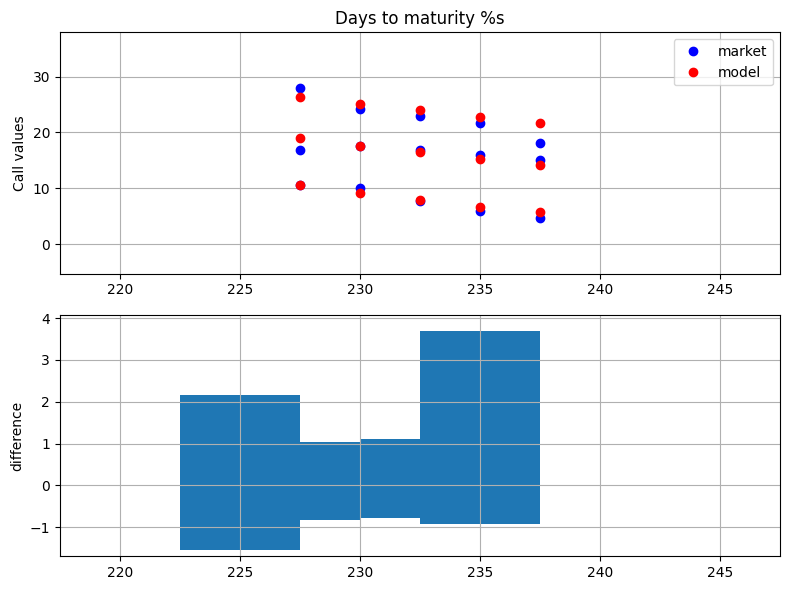

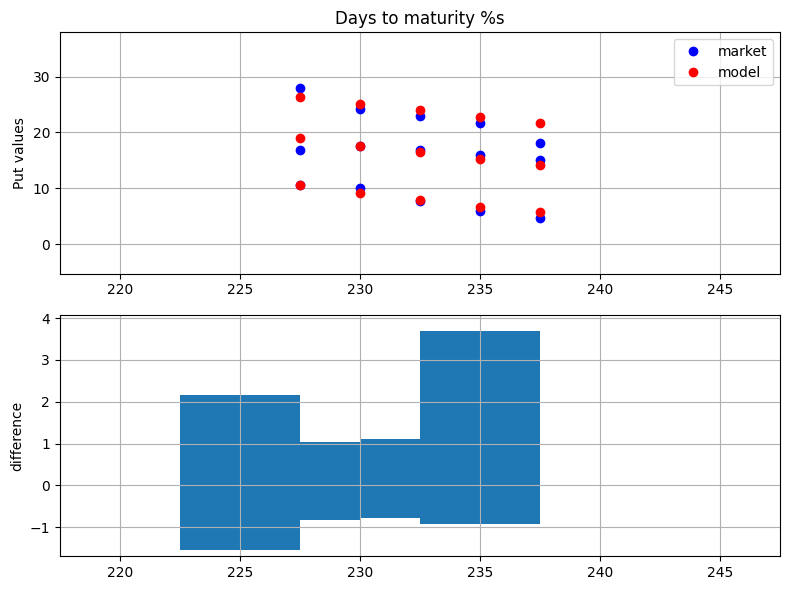

In [ ]:
# Initialize and calibrate model
config = HestonCalibrationConfig(
max_iter = 750,
max_fun = 900,
print_freq = 100,
days_in_year = 250,
atm_tolerance = 0.02,
maturity_target = 15, # switch to None to allow all maturities
is_lewis = True
)
heston_lewis = HestonModel(S0, r, config=config)
params = heston_lewis.calibrate(options)

print("\nHeston (1993) Calibrated parameters under Lewis approch:")
for param, value in params.items():
    print(f"{param}: {value:.3f}")

plot_calibration_results = plotCalibration(heston_lewis, options)
plot_calibration_results.plot(is_call = True)
plot_calibration_results.plot(is_call = False)

Starting brute force global search...

Starting local optimization...
Iter  100 | Params: [ 4.30106945  0.12916625  0.00729077 -0.01104804  0.10960729] | MSE: 15.052928 | Best: 15.052917
Iter  200 | Params: [ 4.31827957e+00  1.44045693e-01  2.08324920e-06 -1.12524449e-02
  1.07696079e-01] | MSE: 15.052885 | Best: 15.052777
Iter  300 | Params: [ 4.31731885e+00  1.44041598e-01  1.20156062e-06 -1.12509605e-02
  1.07696991e-01] | MSE: 15.052823 | Best: 15.052589
Iter  400 | Params: [ 4.31731762e+00  1.44041592e-01  1.20123505e-06 -1.12509591e-02
  1.07696994e-01] | MSE: 15.052699 | Best: 15.052589
Iter  500 | Params: [ 4.31731762e+00  1.44041592e-01  1.20123255e-06 -1.12509591e-02
  1.07696994e-01] | MSE: 15.052708 | Best: 15.052589
Optimization terminated successfully.
         Current function value: 15.052589
         Iterations: 275
         Function evaluations: 638

Calibration complete!
Minimum MSE achieved: 15.052589

Heston (1993) Calibrated parameters under Carr-Madan approch:
ka

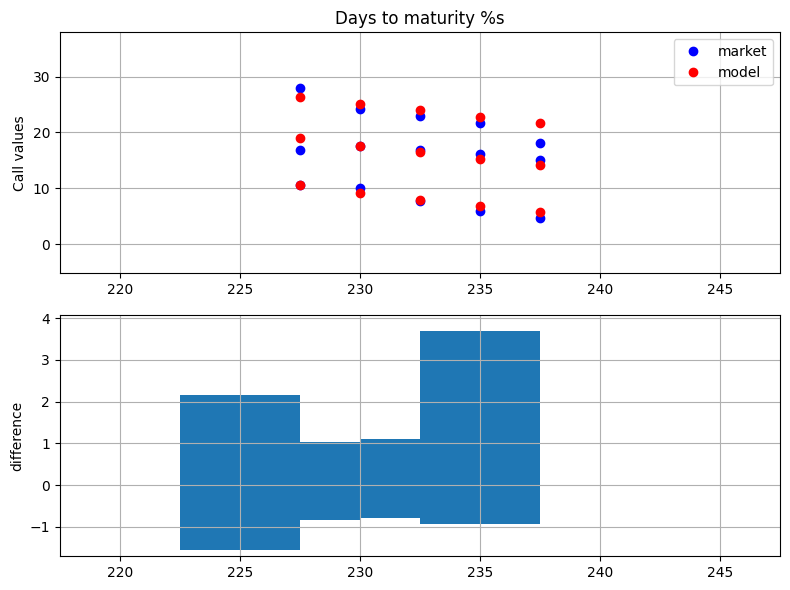

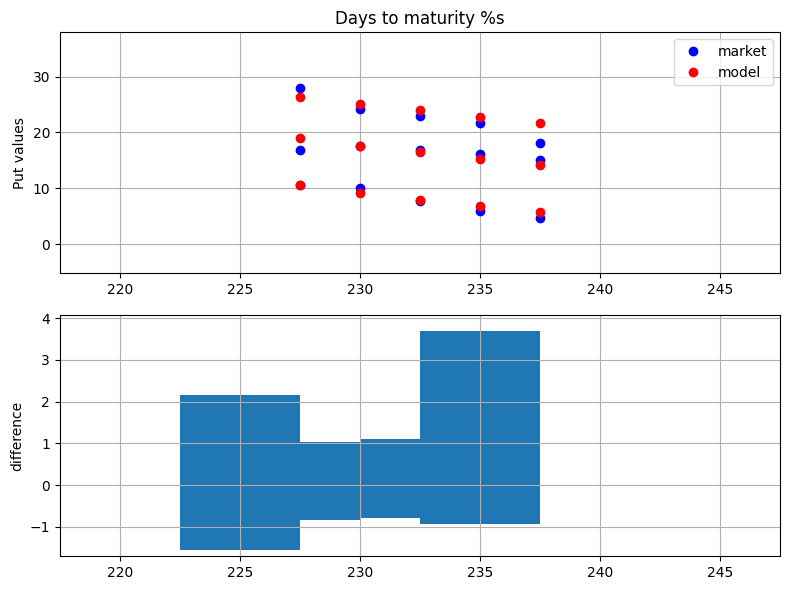

In [ ]:
# Initialize and calibrate model
config = HestonCalibrationConfig(
max_iter = 750,
max_fun = 900,
print_freq = 100,
days_in_year = 250,
atm_tolerance = 0.02,
maturity_target = 15, # set to None to allow all maturities instruments
is_lewis = False
)
heston = HestonModel(S0, r, config=config)
params = heston.calibrate(options)

print("\nHeston (1993) Calibrated parameters under Carr-Madan approch:")
for param, value in params.items():
    print(f"{param}: {value:.3f}")

plot_calibration_results = plotCalibration(heston, options)
plot_calibration_results.plot(is_call = True)
plot_calibration_results.plot(is_call = False)

So, this is the parameters resulting from calibration of the Heston (1993) model:

- $\kappa_\nu = 4.317318$
- $\theta_\nu = 0.144042$
- $\sigma_\nu = 0.000001$
- $\rho = -0.011251$
- $\nu_0 = 0.107697$

## Pricing Asian option

#### Pricer architechture


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from dataclasses import dataclass
from typing import Optional, Tuple
import warnings

@dataclass
class ConfigAsianOptionHeston:
    n_simulations: int = 10_000
    n_steps: int = 250
    averaging_period: float = 0.2  # Fraction of total period for averaging
    show_trajectories: int = 30
    seed: Optional[int] = None

class AsianOptionHeston:
    def __init__(self, model, config: Optional[ConfigAsianOptionHeston] = None):
        """
        Asian option pricer with Heston stochastic volatility model.

        Args:
            model: Heston model instance with calibrated parameters
            config: Configuration for simulation
        """
        self.model = model
        self.config = config if config else ConfigAsianOptionHeston()
        self.K: Optional[float] = None
        self.T: Optional[float] = None
        self.payoffs: Optional[np.ndarray] = None
        self.option_price: Optional[float] = None
        self.S_paths: Optional[np.ndarray] = None
        self.v_paths: Optional[np.ndarray] = None

        if self.config.seed is not None:
            np.random.seed(self.config.seed)

    def option_value(self, S0: float, K: float, T: float, is_call: bool = True) -> float:
        """
        Price an Asian option using Monte Carlo simulation under Heston model.

        Args:
            S0: Initial asset price
            K: Strike price
            T: Time to maturity in years
            is_call: True for call option, False for put

        Returns:
            Option price
        """
        self.K = K
        self.T = T

        # Get model parameters
        params = self.model.get_parameters()
        kappa_v = params['kappa_v']
        theta_v = params['theta_v']
        sigma_v = params['sigma_v']
        rho = params['rho']
        v0 = params['v0']
        r = self.model.r

        dt = T / self.config.n_steps
        n_averaging_steps = max(1, int(self.config.averaging_period * self.config.n_steps))

        # Initialize arrays
        self.S_paths = np.zeros((self.config.n_simulations, self.config.n_steps))
        self.v_paths = np.zeros_like(self.S_paths)
        self.S_paths[:, 0] = S0
        self.v_paths[:, 0] = v0

        # Generate correlated Brownian motions
        Z = np.random.multivariate_normal(
            mean=[0, 0],
            cov=[[1, rho], [rho, 1]],
            size=(self.config.n_steps - 1, self.config.n_simulations)
        )

        # Euler-Maruyama discretization with full truncation
        for t in range(1, self.config.n_steps):
            sqrt_v = np.sqrt(np.maximum(self.v_paths[:, t-1], 0))
            sqrt_dt = np.sqrt(dt)

            # Variance process
            self.v_paths[:, t] = np.maximum(
                self.v_paths[:, t-1] +
                kappa_v * dt * (theta_v - np.maximum(self.v_paths[:, t-1], 0)) +
                sigma_v * sqrt_v * sqrt_dt * Z[t-1, :, 0],
                0
            )

            # Stock price process
            self.S_paths[:, t] = self.S_paths[:, t-1] * (
                1 + r * dt +
                sqrt_v * sqrt_dt * Z[t-1, :, 1]
            )

        # Calculate average price over the averaging period
        S_avg = np.mean(self.S_paths[:, -n_averaging_steps:], axis=1)

        # Compute payoffs
        if is_call:
            self.payoffs = np.maximum(S_avg - K, 0)
        else:
            self.payoffs = np.maximum(K - S_avg, 0)

        # Discount and average
        self.option_price = np.exp(-r * T) * np.mean(self.payoffs)

        return self.option_price

    def option_final_price(self, S0: float, K: float, T: float, charge: float, is_call: bool = True) -> float:
        if not self.option_price:
            option_price = self.option_value(S0, K, T, is_call)
        else:
            option_price = self.option_price
        return option_price * (charge + 1)

    def plot_trajectories(self, n_trajectories: Optional[int] = None) -> None:
        """Plot sample price trajectories."""
        if self.S_paths is None:
            raise ValueError("Run simulation first with option_value()")

        n_trajectories = n_trajectories or self.config.show_trajectories
        n_trajectories = min(n_trajectories, self.config.n_simulations)

        plt.figure(figsize=(10, 6))
        for i in range(n_trajectories):
            plt.plot(np.linspace(0, self.T, self.config.n_steps),
                    self.S_paths[i, :],
                    alpha=0.6, linewidth=0.8)

        plt.title(f"{n_trajectories} Sample Price Trajectories")
        plt.xlabel("Time (years)")
        plt.ylabel("Asset Price")
        plt.grid(True)
        plt.show()

    def prob_option_zero_and_density(self) -> Tuple[float, plt.Figure]:
        """
        Compute probability that option expires worthless and plot payoff density.

        Returns:
            Tuple of (probability, matplotlib figure)
        """
        if self.payoffs is None:
            raise ValueError("Run simulation first with option_value()")

        prob_zero = np.mean(self.payoffs <= 0)
        print(f"Probability that Payoff is 0: {prob_zero:.2%}")

        fig = plt.figure(figsize=(10, 6))

        # Histogram
        plt.hist(self.payoffs, bins=50, density=True, alpha=0.6,
                color='b', label="Payoff Distribution")

        # KDE
        kde = gaussian_kde(self.payoffs)
        x_vals = np.linspace(0, np.max(self.payoffs), 500)
        plt.plot(x_vals, kde(x_vals), 'r-', label="Density Estimate")

        plt.title("Option Payoff Distribution")
        plt.xlabel("Payoff")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)

        return prob_zero, fig

    def convergence_test(self, S0: float, K: float, T: float,
                        is_call: bool = True, n_points: int = 10) -> plt.Figure:
        """
        Test convergence of option price with increasing number of simulations.

        Returns:
            matplotlib figure
        """
        n_simulations = np.logspace(3, np.log10(self.config.n_simulations), n_points).astype(int)
        prices = []

        original_n_simulations = self.config.n_simulations

        for n in n_simulations:
            self.config.n_simulations = n
            prices.append(self.option_value(S0, K, T, is_call))

        self.config.n_simulations = original_n_simulations

        fig = plt.figure(figsize=(10, 6))
        plt.plot(n_simulations, prices, 'bo-')
        plt.xscale('log')
        plt.title("Monte Carlo Convergence")
        plt.xlabel("Number of Simulations (log scale)")
        plt.ylabel("Option Price")
        plt.grid(True)

        return fig

### Princing results


In [ ]:
# Option characteristics
S0 = 232.90
K = S0 # ATM
T = 20 / 250
charge = 4 / 100

Option fair price: $5.11
Option client price: $5.31
Probability that Payoff is 0: 50.65%


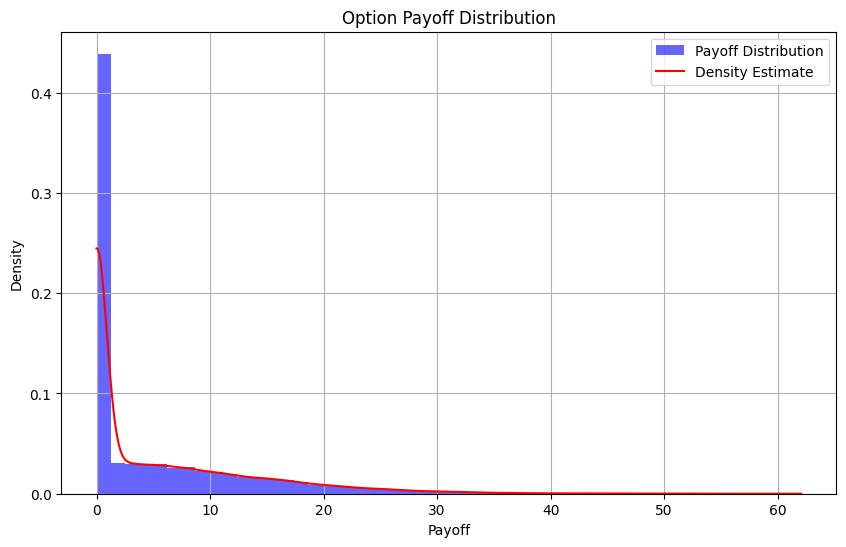

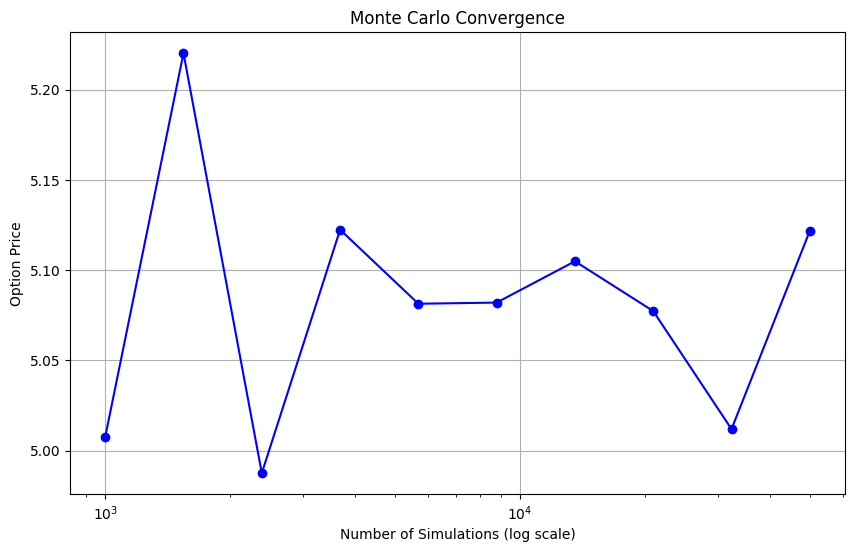

In [ ]:
# Pricer configuration
config = ConfigAsianOptionHeston(
    n_simulations=50_000,
    n_steps=250,  # daily step
    averaging_period=1,  # The whole period
    seed=42
)

# Pricing
asian_option_1 = AsianOptionHeston(heston, config)
price = asian_option_1.option_final_price(S0=S0, K=K, T=T, charge=charge, is_call=True)

# Results
print(f"Option fair price: ${asian_option_1.option_price:.2f}")
print(f"Option client price: ${price:.2f}")

#asian_option.plot_trajectories()
prob_zero, fig = asian_option_1.prob_option_zero_and_density()
convergence_fig = asian_option_1.convergence_test(S0=S0, K=K, T=T)

# Step 2

##  Calibrate Bates (1996) model

In [ ]:
from scipy.optimize import brute, fmin
from typing import Dict, Tuple, Optional
from dataclasses import dataclass
import warnings

@dataclass
class BatesCalibrationConfig:
    H93_brute_force_ranges: Tuple[Tuple[float, float, float], ...] = (
        (2.5, 10.6, 5.0),    # kappa_v
        (0.01, 0.041, 0.01), # theta_v
        (0.05, 0.251, 0.1),  # sigma_v
        (-0.75, 0.01, 0.25), # rho
        (0.01, 0.031, 0.01),  # v0
    )
    M76J_brute_force_ranges: Tuple[Tuple[float, float, float], ...] = (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25), # delta
            )
    opt_tol: float = 1e-6
    max_iter: int = 750
    max_fun: int = 900
    print_freq: int = 25
    days_in_year: int = 250
    atm_tolerance: float = 0.02
    maturity_target: int = None
    is_lewis: bool = False

class BatesModel:
    """
    Implements the Bates model for option pricing with calibration capabilities.

    Parameters:
    -----------
    S0 : float
        Initial asset price
    r : float
        Risk-free interest rate
    config : HestonCalibrationConfig
        Configuration for calibration process
    """

    def __init__(self, S0: float, r: float, config: Optional[BatesCalibrationConfig] = None):
        self.S0 = float(S0)
        self.r = float(r)
        self.config = config if config is not None else HestonCalibrationConfig()

        # Model parameters (to be calibrated)
        # Stchastic volatility params
        self.kappa_v: float = None  # Mean reversion speed
        self.theta_v: float = None  # Long-term variance
        self.sigma_v: float = None  # Vol of vol
        self.rho:float = None      # Correlation
        self.v0:float = None       # Initial variance

        # Jump params
        self.lamb: float = None  # Jump intensity
        self.mu: float = None    # Jump size
        self.delta: float = None  # Jump vol

        # Calibration state
        self._calibration_data = None
        self._min_mse = 500
        self._iteration = 0
        self._heston_params = None

    def calibrate(self, options: pd.DataFrame) -> Dict[str, float]:
        """
        Calibrate the Heston model parameters to market option prices.

        Parameters:
        -----------
        options : pd.DataFrame
            Market options data with columns: ['Strike', 'Price', 'Days to maturity', 'Type']

        Returns:
        --------
        Dict with calibrated parameters
        """

        # First step: calibrate heston params
        self._prepare_calibration_data(options)

        heston_config = HestonCalibrationConfig(
        self.config.H93_brute_force_ranges,
        self.config.opt_tol,
        self.config.max_iter,
        self.config.max_fun,
        self.config.print_freq,
        self.config.days_in_year,
        self.config.atm_tolerance,
        self.config.maturity_target,
        self.config.is_lewis)
        heston_model = HestonModel(self.S0, self.r, config=heston_config)
        opt1 = heston.calibrate(options)
        self._heston_params = opt1.values()

        # Jump calibration
        opt_J = self._M76J_calibration(options)
        opt2 = list(self._heston_params)
        opt2.extend(list(opt_J))
        opt2 = np.array(opt2)

        # Full calibration
        print("\nStarting full calibration ...")
        self._iteration = 0
        self._min_mse = 5000
        opt_result = fmin(
            self._error_function,
            opt2,
            xtol=self.config.opt_tol,
            ftol=self.config.opt_tol,
            maxiter=self.config.max_iter,
            maxfun=self.config.max_fun
        )

        self.kappa_v, self.theta_v, self.sigma_v, self.rho, self.v0, self.lamb, self.mu, self.delta = opt_result
        print("\nCalibration complete!")
        print(f"Minimum MSE achieved: {self._min_mse:.6f}")

        return self.get_parameters()

    def _M76J_error_func(self, p0):
            params = list(self._heston_params)
            params.extend(list(p0))
            params = np.array(params)
            return self._error_function(params)

    def _M76J_calibration(self, options):
        self._prepare_calibration_data(options)

        # Second step: calibrate jump params
        print("Starting brute force global search M76J...")
        p0 = brute(
            self._M76J_error_func,
            self.config.M76J_brute_force_ranges,
            finish=None,
        )

        print("\nStarting local optimization M76J...")
        opt2 = fmin(
            self._M76J_error_func,
            p0,
            xtol=self.config.opt_tol,
            ftol=self.config.opt_tol,
            maxiter=self.config.max_iter,
            maxfun=self.config.max_fun,
            disp=True,
        )
        return opt2


    def get_parameters(self) -> Dict[str, float]:
        """Return current model parameters as a dictionary."""
        return {
            'kappa_v': self.kappa_v,
            'theta_v': self.theta_v,
            'sigma_v': self.sigma_v,
            'rho': self.rho,
            'v0': self.v0,
            'lamb': self.lamb,
            'mu': self.mu,
            'delta': self.delta
        }

    def option_value(self, K: float, T: float, is_call: bool = True) -> float:
        """
        Calculate option price using the calibrated Heston model.

        Parameters:
        -----------
        K : float
            Strike price
        T : float
            Time to maturity in years
        is_call : bool
            Whether to price a call (True) or put (False) option

        Returns:
        --------
        Option price
        """

        if None in [self.kappa_v, self.theta_v, self.sigma_v, self.rho, self.v0]:
            raise ValueError("Model must be calibrated first")

        return self._B96_option_value(
            self.S0, K, T, self.r,
            self.kappa_v, self.theta_v, self.sigma_v, self.rho, self.v0,
            self.lamb, self.mu, self.delta, is_call
        )

    def _prepare_calibration_data(self, options: pd.DataFrame) -> None:
        """Filter and prepare options data for calibration."""
        data = options.copy()
        data['is_call'] = (data['Type'] == 'C')

        # Convert days to years and filter ATM options
        data = data if not self.config.maturity_target else data[
            data["Days to maturity"] == self.config.maturity_target
            ]
        data["T"] = data["Days to maturity"] / self.config.days_in_year
        moneyness = np.abs(data["Strike"] - self.S0) / self.S0
        self._calibration_data = data[moneyness < self.config.atm_tolerance]

        if len(self._calibration_data) == 0:
            raise ValueError("No suitable options found for calibration")

    def get_calibration_data(self):
        return self._calibration_data


    def _error_function(self, params: np.ndarray) -> float:
        """Objective function for calibration (mean squared error)."""
        kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = params

        # Check parameter constraints
        if (kappa_v < 0 or theta_v < 0 or sigma_v < 0 or
            rho < -1 or rho > 1 or v0 < 0 or
            2 * kappa_v * theta_v < sigma_v**2 or
           lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0):
            return 1e6  # Large penalty for invalid parameters

        se = []
        for _, option in self._calibration_data.iterrows():
            model_value = self._B96_option_value(
                self.S0,
                option["Strike"],
                option["T"],
                self.r,
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
                lamb,
                mu,
                delta,
                option["is_call"]
            )
            se.append((model_value - option["Price"])**2)

        mse = np.mean(se)


        # Track progress
        self._iteration += 1
        self._min_mse = min(self._min_mse, mse)
        if self._iteration % self.config.print_freq == 0:
            print(f"Iter {self._iteration:4d} | Params: {params} | MSE: {mse:.6f} | Best: {self._min_mse:.6f}")

        return mse

    def _B96_option_value(self, S0, K, T, r,
                         kappa_v, theta_v, sigma_v, rho, v0,
                         lamb, mu, delta,
                         is_call):
        if self.config.is_lewis:
            CallValue =  self._B96_option_value_Lewis(S0, K, T, r,
                         kappa_v, theta_v, sigma_v, rho, v0,
                         lamb, mu, delta)
        else:
            CallValue = self._B96_option_value_FFT(S0, K, T, r,
                         kappa_v, theta_v, sigma_v, rho, v0,
                         lamb, mu, delta)
        if is_call:
            return CallValue
        else:
            PutValue = CallValue + S0 - K * np.exp(-r * T)
            return PutValue

    def _B96_option_value_Lewis(self, S0: float, K: float, T: float, r: float,
                     kappa_v: float, theta_v: float, sigma_v: float,
                     rho: float, v0: float, lamb: float, mu: float, delta: float) -> float:
        """Calculate option price using Lewis method."""
        int_value = quad(
            lambda u: self._B96_int_func(
                u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0,
                lamb, mu, delta
            ),
            0,
            np.inf,
            limit=250,
            )[0]
        CallValue = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
        return CallValue

    def _B96_int_func(self, u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
        """
        Lewis (2001) integral value for Bates (1996) characteristic function
        """
        char_func_value = self._B96_char_func(
            u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        )
        int_func_value = (
            1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
        )
        return int_func_value

    def _B96_char_func(self, u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
        """
        Bates (1996) characteristic function
        """
        H93 = self._H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
        M76J = self._M76J_char_func(u, T, lamb, mu, delta)
        return H93 * M76J

    @staticmethod
    def _H93_char_func(u: complex,
                       T:float,
                       r: float,
                       kappa_v:float,
                       theta_v: float,
                       sigma_v: float,
                       rho: float,
                       v0: float):
        """Valuation of European call option in H93 model via Lewis (2001)
        Fourier-based approach: characteristic function.
        Parameter definitions see function BCC_call_value."""
        c1 = kappa_v * theta_v
        c2 = -np.sqrt(
            (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
        )
        c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
            kappa_v - rho * sigma_v * u * 1j - c2
        )
        H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
            (kappa_v - rho * sigma_v * u * 1j + c2) * T
            - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
        )
        H2 = (
            (kappa_v - rho * sigma_v * u * 1j + c2)
            / sigma_v**2
            * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
        )
        char_func_value = np.exp(H1 + H2 * v0)
        return char_func_value

    @staticmethod
    def _M76J_char_func(u, T, lamb, mu, delta):
        """
        Adjusted Characteristic function for Merton '76 model: Only jump component
        """

        omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
        char_func_value = np.exp(
            (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
            * T
        )
        return char_func_value


    def _B96_option_value_FFT(self, S0: float, K: float, T: float, r: float,
                         kappa_v: float, theta_v: float, sigma_v: float,
                         rho: float, v0: float,
                        lamb: float, mu: float, delta: float) -> float:
        """Calculate option price using FFT method."""
        k = np.log(K / S0)
        g = 1  # Factor to increase accuracy
        N = g * 4096
        eps = (g * 150) ** -1
        eta = 2 * np.pi / (N * eps)
        b = 0.5 * N * eps - k
        u = np.arange(1, N + 1, 1)
        vo = eta * (u - 1)

        # Modifications to ensure integrability
        if S0 >= 0.95 * K:  # ITM Case
            alpha = 1.5
            v = vo - (alpha + 1) * 1j
            modcharFunc = np.exp(-r * T) * (
                self._B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0,
                                   lamb, mu, delta)
                / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
            )

        else:
            alpha = 1.1
            v = (vo - 1j * alpha) - 1j
            modcharFunc1 = np.exp(-r * T) * (
                1 / (1 + 1j * (vo - 1j * alpha))
                - np.exp(r * T) / (1j * (vo - 1j * alpha))
                - self._B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0,
                                   lamb, mu, delta)
                / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
            )

            v = (vo + 1j * alpha) - 1j

            modcharFunc2 = np.exp(-r * T) * (
                1 / (1 + 1j * (vo + 1j * alpha))
                - np.exp(r * T) / (1j * (vo + 1j * alpha))
                - self._B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0,
                                   lamb, mu, delta)
                / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
            )

        # Numerical FFT Routine
        delt = np.zeros(N)
        delt[0] = 1
        j = np.arange(1, N + 1, 1)
        SimpsonW = (3 + (-1) ** j - delt) / 3
        if S0 >= 0.95 * K:
            FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
            payoff = (np.fft.fft(FFTFunc)).real
            CallValueM = np.exp(-alpha * k) / np.pi * payoff
        else:
            FFTFunc = (
                np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
            )
            payoff = (np.fft.fft(FFTFunc)).real
            CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

        pos = int((k + b) / eps)
        CallValue = CallValueM[pos] * S0

        return CallValue


## Runnig calibration

Starting brute force global search...
Iter  600 | Params: [ 2.5   0.01  0.05 -0.25  0.01] | MSE: 41.451737 | Best: 15.052589
Iter  600 | Params: [ 2.5   0.02  0.05 -0.25  0.01] | MSE: 40.733426 | Best: 15.052589
Iter  600 | Params: [ 2.5   0.03  0.05 -0.25  0.01] | MSE: 40.042828 | Best: 15.052589
Iter  600 | Params: [ 2.5   0.04  0.05 -0.25  0.01] | MSE: 39.377974 | Best: 15.052589
Iter  600 | Params: [ 7.5   0.01  0.05 -0.25  0.01] | MSE: 41.445922 | Best: 15.052589
Iter  600 | Params: [ 7.5   0.02  0.05 -0.25  0.01] | MSE: 39.551553 | Best: 15.052589
Iter  600 | Params: [ 7.5   0.03  0.05 -0.25  0.01] | MSE: 37.839657 | Best: 15.052589
Iter  600 | Params: [ 7.5   0.04  0.05 -0.25  0.01] | MSE: 36.280105 | Best: 15.052589

Starting local optimization...
Iter  600 | Params: [7.65e+00 4.08e-02 4.75e-02 1.00e-04 3.06e-02] | MSE: 26.816276 | Best: 15.052589
Iter  700 | Params: [ 4.28274042  0.13044078  0.00673858 -0.01107325  0.10966519] | MSE: 15.052920 | Best: 15.052589
Iter  800 | Par

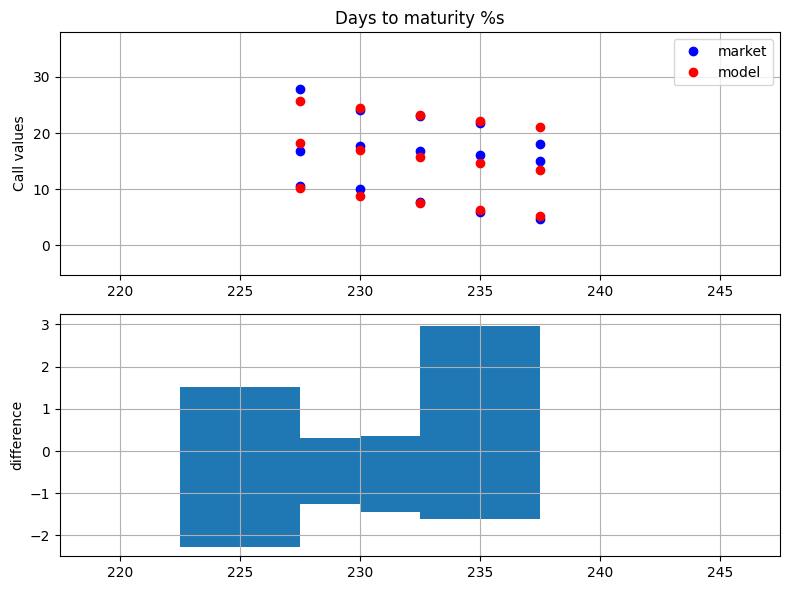

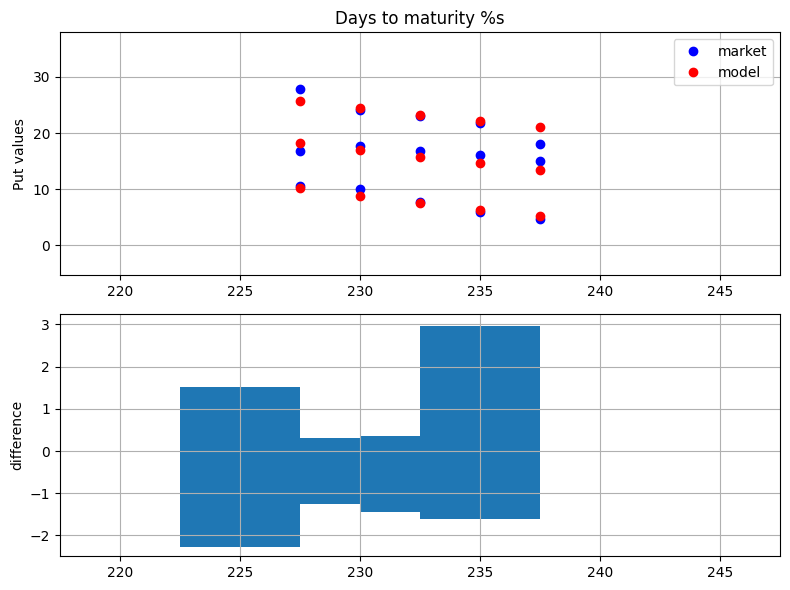

In [ ]:

# Initialize and calibrate model
config = BatesCalibrationConfig(
max_iter = 750,
max_fun = 900,
print_freq = 100,
days_in_year = 250,
atm_tolerance = 0.02,
maturity_target = 60, # set to None to allow all maturities instrument
is_lewis = False
)
bates = BatesModel(S0, r, config=config)
params = bates.calibrate(options)

print("\nCalibrated of Bates (1996) parameters under Carr-Madan:")
for param, value in params.items():
    print(f"{param}: {value:.3f}")

bates_calibration_results = plotCalibration(bates, options)
bates_calibration_results.plot(is_call = True)
bates_calibration_results.plot(is_call = False)


Starting brute force global search...
Iter 1200 | Params: [ 2.5   0.01  0.15 -0.75  0.02] | MSE: 34.195683 | Best: 15.052589
Iter 1200 | Params: [ 2.5   0.02  0.15 -0.75  0.02] | MSE: 33.718523 | Best: 15.052589
Iter 1200 | Params: [ 2.5   0.03  0.15 -0.75  0.02] | MSE: 33.254973 | Best: 15.052589
Iter 1200 | Params: [ 2.5   0.04  0.15 -0.75  0.02] | MSE: 32.804387 | Best: 15.052589
Iter 1200 | Params: [ 7.5   0.01  0.15 -0.75  0.02] | MSE: 35.009973 | Best: 15.052589
Iter 1200 | Params: [ 7.5   0.02  0.15 -0.75  0.02] | MSE: 33.679025 | Best: 15.052589
Iter 1200 | Params: [ 7.5   0.03  0.15 -0.75  0.02] | MSE: 32.448665 | Best: 15.052589
Iter 1200 | Params: [ 7.5   0.04  0.15 -0.75  0.02] | MSE: 31.306836 | Best: 15.052589

Starting local optimization...
Iter 1200 | Params: [ 7.5876960e+00  4.2579712e-02  4.8482400e-02 -2.4393600e-04
  3.3374784e-02] | MSE: 25.794805 | Best: 15.052589
Iter 1300 | Params: [ 4.30282627  0.13011276  0.00693797 -0.01108148  0.10962449] | MSE: 15.052914 | 

/tmp/ipython-input-11-2233630727.py:276: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(



Starting local optimization M76J...
Iter  100 | Params: [ 4.31731762e+00  1.44041592e-01  1.20123255e-06 -1.12509591e-02
  1.07696994e-01  1.49011612e-11 -5.08333333e-01  8.33333284e-05] | MSE: 16.603014 | Best: 16.603014
Optimization terminated successfully.
         Current function value: 16.603014
         Iterations: 61
         Function evaluations: 162

Starting full calibration ...
Iter  100 | Params: [ 4.38004109e+00  1.40489001e-01  1.26334725e-06 -1.18761568e-02
  9.35236624e-02  1.41420579e-14 -5.18471888e-01  3.55860759e-05] | MSE: 16.162969 | Best: 16.162969
Iter  200 | Params: [ 4.37379934e+00  1.40458428e-01  1.26158522e-06 -1.18287787e-02
  9.37211465e-02  1.41331063e-14 -5.17685801e-01  3.56102910e-05] | MSE: 16.162965 | Best: 16.162046
Iter  300 | Params: [ 4.37379220e+00  1.40459024e-01  1.26158814e-06 -1.18287177e-02
  9.37215356e-02  1.41332006e-14 -5.17674692e-01  3.56104523e-05] | MSE: 16.162968 | Best: 16.162046
Iter  400 | Params: [ 4.37379300e+00  1.40459028

/tmp/ipython-input-11-2233630727.py:276: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


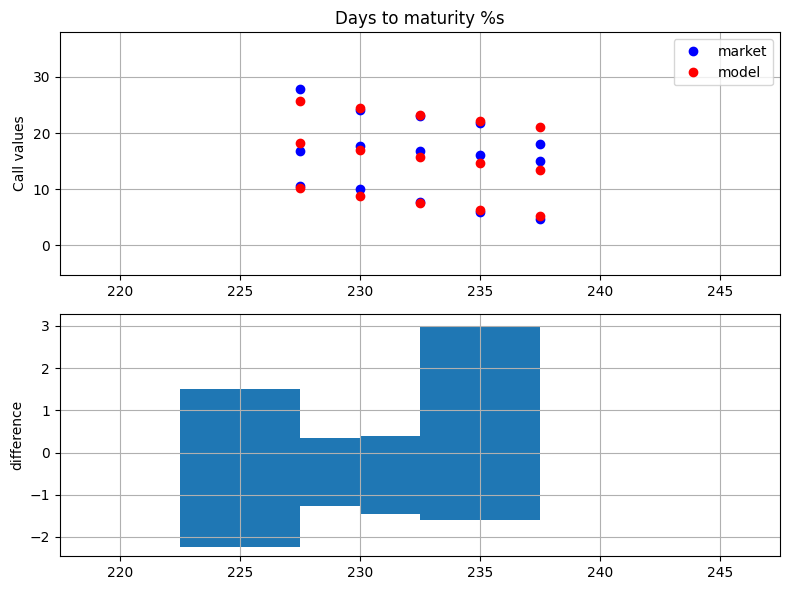

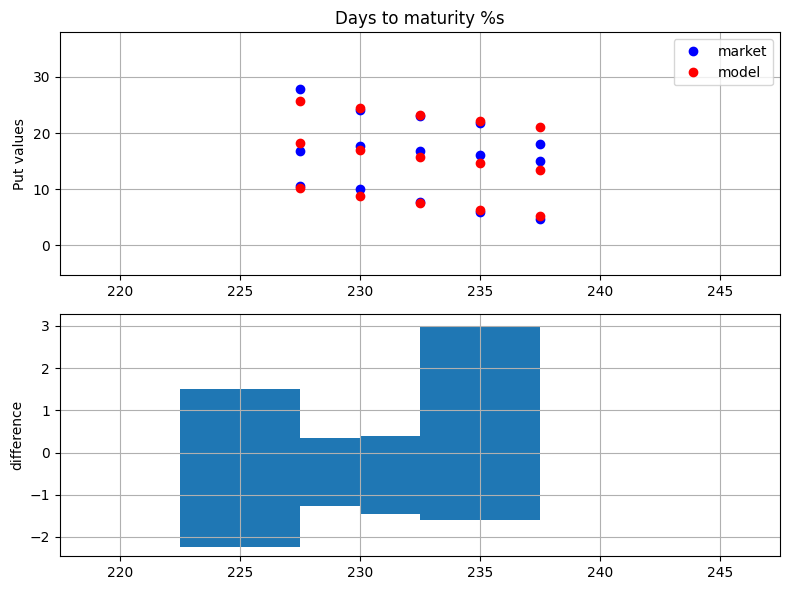

In [ ]:

# Initialize and calibrate model
config = BatesCalibrationConfig(
max_iter = 750,
max_fun = 900,
print_freq = 100,
days_in_year = 250,
atm_tolerance = 0.02,
maturity_target = 60,
is_lewis = True
)
bates_lewis = BatesModel(S0, r, config=config)
params = bates_lewis.calibrate(options)

print("\nCalibrated of Bates (1996) parameters under Lewis:")
for param, value in params.items():
    print(f"{param}: {value:.3f}")

bates_calibration_results = plotCalibration(bates_lewis, options)
bates_calibration_results.plot(is_call = True)
bates_calibration_results.plot(is_call = False)

## Pricing Asion Option

### Pricer architecture

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from dataclasses import dataclass
from typing import Optional, Tuple
import warnings

@dataclass
class ConfigAsianOptionBates:
    n_simulations: int = 10_000
    n_steps: int = 250
    averaging_period: float = 0.2  # Fraction of total period for averaging
    show_trajectories: int = 30
    seed: Optional[int] = None

class AsianOptionBates:
    def __init__(self, model, config: Optional[ConfigAsianOptionBates] = None):
        """
        Asian option pricer with Heston stochastic volatility model.

        Args:
            model: Heston model instance with calibrated parameters
            config: Configuration for simulation
        """
        self.model = model
        self.config = config if config else ConfigAsianOptionBates()
        self.K: Optional[float] = None
        self.T: Optional[float] = None
        self.payoffs: Optional[np.ndarray] = None
        self.option_price: Optional[float] = None
        self.S_paths: Optional[np.ndarray] = None
        self.v_paths: Optional[np.ndarray] = None

        if self.config.seed is not None:
            np.random.seed(self.config.seed)

    def option_value(self, S0: float, K: float, T: float, is_call: bool = True) -> float:
        """
        Price an Asian option using Monte Carlo simulation under Heston model.

        Args:
            S0: Initial asset price
            K: Strike price
            T: Time to maturity in years
            is_call: True for call option, False for put

        Returns:
            Option price
        """
        self.K = K
        self.T = T

        # Get model parameters
        params = self.model.get_parameters()
        kappa_v = params['kappa_v']
        theta_v = params['theta_v']
        sigma_v = params['sigma_v']
        rho = params['rho']
        v0 = params['v0']

        # Jum params
        lamb = params['lamb']
        mu = params['mu']
        delta = params['delta']
        r = self.model.r

        dt = T / self.config.n_steps
        n_averaging_steps = max(1, int(self.config.averaging_period * self.config.n_steps))

        # Initialize arrays
        self.S_paths = np.zeros((self.config.n_simulations, self.config.n_steps))
        self.v_paths = np.zeros_like(self.S_paths)
        self.S_paths[:, 0] = S0
        self.v_paths[:, 0] = v0

        # Generate correlated Brownian motions
        Z = np.random.multivariate_normal(
            mean=[0, 0],
            cov=[[1, rho], [rho, 1]],
            size=(self.config.n_steps - 1, self.config.n_simulations)
        )
        Z_J = np.random.normal(
            size=(self.config.n_steps - 1, self.config.n_simulations)
        )
        jump = np.random.poisson(lam=lamb,
                                 size=(self.config.n_steps - 1, self.config.n_simulations),
                                )

        # Euler-Maruyama discretization with full truncation
        for t in range(1, self.config.n_steps):
            sqrt_v = np.sqrt(np.maximum(self.v_paths[:, t-1], 0))
            sqrt_dt = np.sqrt(dt)

            # Variance process
            self.v_paths[:, t] = np.maximum(
                self.v_paths[:, t-1] +
                kappa_v * dt * (theta_v - np.maximum(self.v_paths[:, t-1], 0)) +
                sigma_v * sqrt_v * sqrt_dt * Z[t-1, :, 0],
                0
            )

            # Stock price process
            self.S_paths[:, t] = self.S_paths[:, t-1] * (
                1 + (r - (lamb * np.exp(mu + 0.5 * delta**2) - 1)) * dt +
                sqrt_v * sqrt_dt * Z[t-1, :, 1] +
                jump[t-1, :] * (
                    1 + np.exp(
                        mu + delta * Z_J[t-1, :]
                    )
                )
            )

        # Calculate average price over the averaging period
        S_avg = np.mean(self.S_paths[:, -n_averaging_steps:], axis=1)

        # Compute payoffs
        if is_call:
            self.payoffs = np.maximum(S_avg - K, 0)
        else:
            self.payoffs = np.maximum(K - S_avg, 0)

        # Discount and average
        self.option_price = np.exp(-r * T) * np.mean(self.payoffs)

        return self.option_price

    def option_final_price(self, S0: float, K: float, T: float, charge: float, is_call: bool = True) -> float:
        if not self.option_price:
            option_price = self.option_value(S0, K, T, is_call)
        else:
            option_price = self.option_price
        return option_price * (charge + 1)

    def plot_trajectories(self, n_trajectories: Optional[int] = None) -> None:
        """Plot sample price trajectories."""
        if self.S_paths is None:
            raise ValueError("Run simulation first with option_value()")

        n_trajectories = n_trajectories or self.config.show_trajectories
        n_trajectories = min(n_trajectories, self.config.n_simulations)

        plt.figure(figsize=(10, 6))
        for i in range(n_trajectories):
            plt.plot(np.linspace(0, self.T, self.config.n_steps),
                    self.S_paths[i, :],
                    alpha=0.6, linewidth=0.8)

        plt.title(f"{n_trajectories} Sample Price Trajectories")
        plt.xlabel("Time (years)")
        plt.ylabel("Asset Price")
        plt.grid(True)
        plt.show()

    def prob_option_zero_and_density(self) -> Tuple[float, plt.Figure]:
        """
        Compute probability that option expires worthless and plot payoff density.

        Returns:
            Tuple of (probability, matplotlib figure)
        """
        if self.payoffs is None:
            raise ValueError("Run simulation first with option_value()")

        prob_zero = np.mean(self.payoffs <= 0)
        print(f"Probability that Payoff is 0: {prob_zero:.2%}")

        fig = plt.figure(figsize=(10, 6))

        # Histogram
        plt.hist(self.payoffs, bins=50, density=True, alpha=0.6,
                color='b', label="Payoff Distribution")

        # KDE
        kde = gaussian_kde(self.payoffs)
        x_vals = np.linspace(0, np.max(self.payoffs), 500)
        plt.plot(x_vals, kde(x_vals), 'r-', label="Density Estimate")

        plt.title("Option Payoff Distribution")
        plt.xlabel("Payoff")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)

        return prob_zero, fig

    def convergence_test(self, S0: float, K: float, T: float,
                        is_call: bool = True, n_points: int = 10) -> plt.Figure:
        """
        Test convergence of option price with increasing number of simulations.

        Returns:
            matplotlib figure
        """
        n_simulations = np.logspace(3, np.log10(self.config.n_simulations), n_points).astype(int)
        prices = []

        original_n_simulations = self.config.n_simulations

        for n in n_simulations:
            self.config.n_simulations = n
            prices.append(self.option_value(S0, K, T, is_call))

        self.config.n_simulations = original_n_simulations

        fig = plt.figure(figsize=(10, 6))
        plt.plot(n_simulations, prices, 'bo-')
        plt.xscale('log')
        plt.title("Monte Carlo Convergence")
        plt.xlabel("Number of Simulations (log scale)")
        plt.ylabel("Option Price")
        plt.grid(True)

        return fig

### Pricing results

In [ ]:
S0 = 232.9
K = 0.95 * S0
T = 70 / 250
r = 1.5 / 100

In [ ]:
# Pricer configuration
config = ConfigAsianOptionBates(
    n_simulations=10_000,
    n_steps=250,  # daily step
    averaging_period= 1,  # the whole period
    seed=42
)

# Pricing
asian_option_2 = AsianOptionBates(bates, config)
price = asian_option_2.option_final_price(S0=S0, K=K, T=T, charge=charge, is_call=False)

# Results
print(f"Option fair price: ${asian_option_2.option_price:.2f}")
print(f"Option client price: ${price:.2f}")

Option fair price: $0.25
Option client price: $0.26


Probability that Payoff is 0: 96.84%


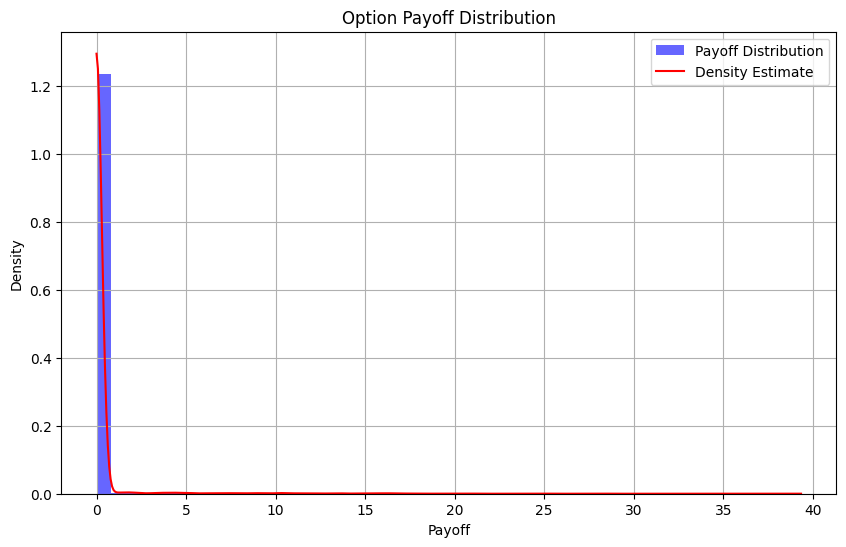

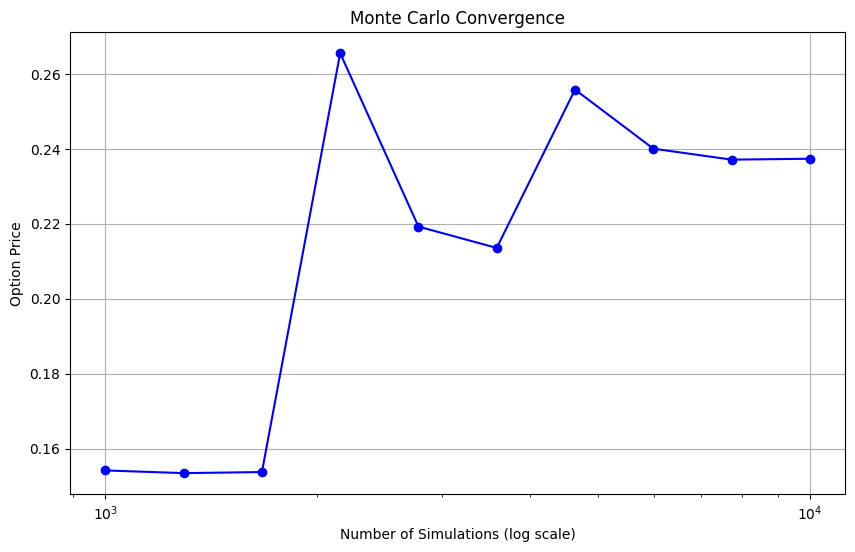

In [ ]:
#asian_option.plot_trajectories()
prob_zero, fig = asian_option_2.prob_option_zero_and_density()
convergence_fig = asian_option_2.convergence_test(S0=S0, K=K, T=T, is_call=False)

# Step 3

## a. Calibrate a CIR (1985) model considering current rates

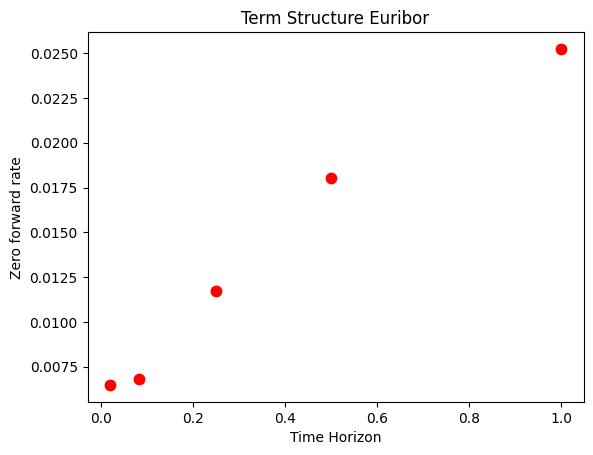

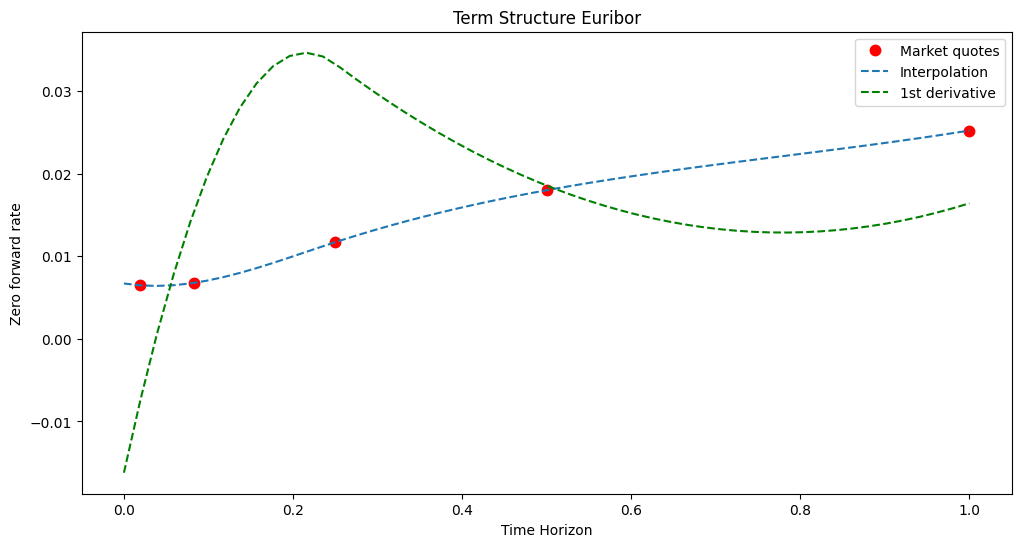

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 84
         Function evaluations: 159
Calibrated parameters:
kappa_r: 1.2823689630648567
theta_r: 0.09969629407752792
sigma_r: 0.006736816380822958


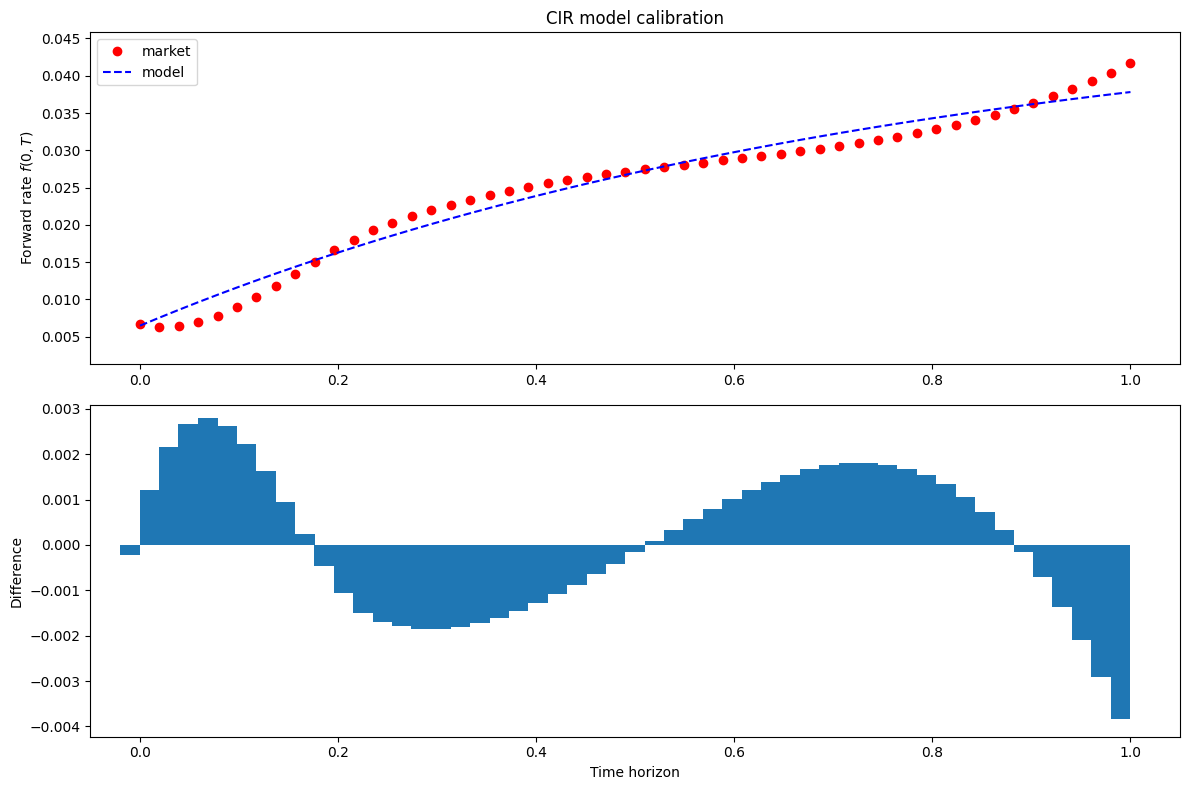

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splev, splrep
from scipy.optimize import fmin

# Euribor rates
mat_list = np.array((7, 30, 90, 180, 360)) / 360
rate_list = np.array((0.648, 0.679, 1.173, 1.809, 2.556)) / 100
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

# Plot term structure
plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

# Cubic spline interpolation
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(0.0, 1.0, 52) # Create 52 equally spaced maturities between 0 and 1 year
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates
first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (inter_rates + first_der * mat_list_n) # Forward rate given interpolated ones and first derivative

# Plot interpolation results
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

# CIR Calibration functions
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)-1)) ** 2)


    return s1 + s2

def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )
    print("Calibrated parameters:")
    print("kappa_r:", opt[0])
    print("theta_r:", opt[1])
    print("sigma_r:", opt[2])

    return opt

# Calibration
params = CIR_calibration()
params

# Plot calibrated parameter
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

plot_calibrated_frc(params)

## b. Given the different CIR model parameters obtained in the previous step, simulate Euribor 12-month rates daily for a period of 1 year. Perform 100,000 Monte-Carlo simulations. Discuss the results obtained (include graphs) regarding: ##

i. Select a level of confidence you are comfortable with, which is the range (max and min) that the 12-month Euribor can take in the next year?

ii. What is the expected value of the 12-month Euribor in 1 year?

iii. How will this expected number affect the pricing of your products in 1 year versus the current 12-month Euribor rate?

At 95% confidence, the 12-month Euribor rate is expected to be between 7.697% and 8.107% in 1 year.
The expected rate is: 7.901%.


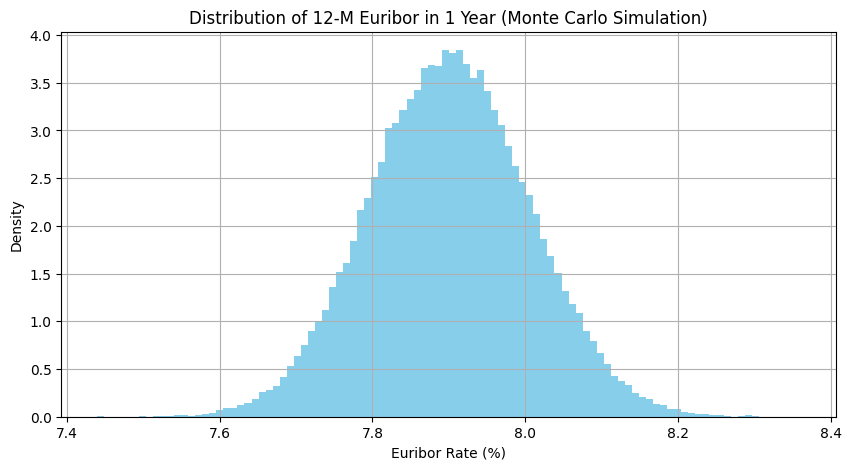

In [ ]:
# CIR model
def cir(r0, kappa, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                kappa * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

# MC simulation
np.random.seed(1)
r0 = zero_rates[-1] # The current Euribor 12-Month rate
T = 1
N = 250
M = 100000
rates_cir = cir(r0, *params, T, N, M)

# i. Range and ii. expected rate
rT = rates_cir[-1, :]  # final rates at time T=1 from all simulations
confidence_level = 0.95
lower_bound = np.percentile(rT, (1 - confidence_level) / 2 * 100)
upper_bound = np.percentile(rT, (1 + confidence_level) / 2 * 100)
expected_rate = np.mean(rT)
print(f"At {int(confidence_level * 100)}% confidence, the 12-month Euribor rate is expected to be between {lower_bound*100:.3f}% and {upper_bound*100:.3f}% in 1 year.")
print(f"The expected rate is: {expected_rate*100:.3f}%.")

# Plot of simulation results
plt.figure(figsize=(10, 5))
plt.hist(rT*100, bins=100, density=True, color="skyblue")
plt.title("Distribution of 12-M Euribor in 1 Year (Monte Carlo Simulation)")
plt.xlabel("Euribor Rate (%)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [ ]:
r0*100

np.float64(2.523880486362555)

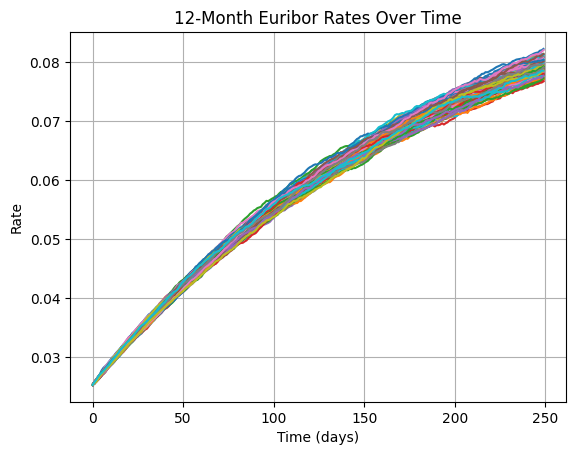

In [ ]:
plt.plot(rates_cir[:,:100])
plt.title("12-Month Euribor Rates Over Time")
plt.xlabel("Time (days)")
plt.ylabel("Rate")
plt.grid(True)
plt.show()